# 🐾 Proje: Aygaz Görüntü İşleme Kampı 🔍

📌 **Projenin Amacı ve Kapsamı**:

Bu proje, **görüntü işleme ve derin öğrenme** tekniklerini kullanarak çeşitli hayvanları sınıflandırmaya yönelik bir model geliştirmeyi amaçlamaktadır. Aygaz Görüntü İşleme Kampı'nda öğrendiğimiz yöntemleri uygulayarak, farklı hayvan türlerini doğru şekilde sınıflandırabilen bir yapay zeka modelinin eğitilmesi hedeflenmiştir. 🐯🐶🐱

Proje kapsamında:

* **Hayvan türleri**: Leopar, Dolphin, Aslan, Tilki, Moose, Tavşan, At, Sincap, Yarasa, ve Goril gibi 10 farklı hayvan türü sınıflandırılmaktadır. 🦁🦊🦏

* **Veri Seti**: Bu proje, hayvan görselleri içeren geniş bir veri setini kullanarak, her bir görseli etiketleyerek modelin doğruluğunu artırmayı hedeflemiştir.

* **Görüntü İşleme Teknikleri**: Görüntülerin parlaklık artırma, renk sabitliği uygulama gibi manipülasyonlarla modellenin dayanıklılığı test edilmiştir. 🔧💡

## **🛠️ Gerekli Kütüphaneler ve İşlevleri:**
* **os, shutil**: Dosya ve klasör yönetimi işlemleri için.
* **cv2 (OpenCV)**: Görüntü işleme ve boyutlandırma için.
* **numpy**: Sayısal hesaplamalar ve veri manipülasyonu için.
* **ImageDataGenerator**: Görüntü veri artırma (augmentation) için.
* **train_test_split**: Eğitim ve test veri setlerini ayırmak için.
* **Model, Dense, Flatten, Dropout, BatchNormalization**: Model katmanlarını oluşturmak için Keras araçları.
* **matplotlib**: Sonuçları görselleştirmek için.
* **keras**: Derin öğrenme modelleme ve işlevsellik için.
* **models, layers**: Keras ile model ve katmanlar oluşturmak için.

In [1]:
import os
import numpy as np
import shutil
import random
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, layers




## 📊**Veri Setinin Hazılanması**
10 Hayvan türünü veri setimizden seçip klasöre taşıyoruz.
1. **Değişkenler ve Parametreler**:

    * **image_size**: Görüntülerin boyutları (128, 128) olarak ayarlanır. 🖼️
    * **classes**: Sınıf isimleri (hayvan türleri) belirlenir. 🐆🦅
    * **images_per_class**: Her sınıf için kullanılacak görüntü sayısı (650). 🖼️
    * **source_dir**: Veri setinin bulunduğu kaynak dizin. 📂
    * **train_dir ve val_dir**: Eğitim ve doğrulama verilerinin depolanacağı dizinler. 📁


2. **Veri Hazırlama Fonksiyonu (prepare_dataset)**:

    * **validation_split**: Eğitim ve doğrulama verilerini ayıran oran (varsayılan %20). 📊


3. **Dizin Oluşturma**:

    * **train_dir** ve **val_dir** içinde her sınıf için uygun alt dizinler oluşturulur. 📂


4. **Resimlerin Seçilmesi ve Karıştırılması**:

    * Her sınıftan **650** kadar görüntü seçilir. 🖼️
    * Görüntüler rastgele karıştırılır (veri çeşitliliği sağlamak için). 🔀


5. **Eğitim ve Doğrulama Verisi Ayırma**:

    * Görüntüler, validation_split oranına göre eğitim ve doğrulama verilerine ayrılır. 📊


6. **Görüntüleri Eğitim ve Doğrulama Dizine Kopyalama**:

    * Seçilen eğitim ve doğrulama verileri uygun dizinlere kopyalanır. 📤📥


7. **Başarıyla Veri Seti Hazırlama**:

    * Veri seti başarıyla hazırlandığında kullanıcıya bilgi verilir. ✅


In [2]:
classes = ["leopard", "dolphin", "lion", "fox", "moose", "rabbit", "horse", "squirrel", "antelope", "gorilla", "cow"]
images_per_class = 650
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
dest_dir = "/kaggle/FImages/FilteredImages/train"


os.makedirs(dest_dir, exist_ok=True)
    
for class_name in classes:
    source_path = os.path.join(source_dir, class_name)
    dest_class_path = os.path.join(dest_dir, class_name)

    os.makedirs(dest_class_path, exist_ok=True)
        
    images = glob(os.path.join(source_path, '*.jpg'))[:images_per_class]
    for img in images:
        shutil.copy(img, dest_class_path)
           

## 🔄**GÖRSELLERİN YÜKLENMESİ 🧩**
Bu adımda, görselleri yükleyip uygun şekilde etiketliyoruz, böylece modelin eğitiminde kullanılacak hale getiriyoruz. 🚀

📌 İşlemler:
1. **Görsel Yükleme**: cv2.imread() ile her bir sınıfın görselleri okunur. 📂
2. **Normalizasyon**: Görseller, modelin daha verimli öğrenmesi için 0-1 aralığına normalleştirilir (img = img / 255.0). ⚖️
3. **Etiketleme**: Her görsel, ait olduğu sınıfın adı ile etiketlenir. 🏷️

📍 Sonuçlar:
* **X**: Ön işlenmiş tüm görseller.
* **y**: Her görselin doğru sınıf etiketi.

In [3]:
def load_images(data_dir, allowed_classes):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        if class_name not in allowed_classes:
            continue  
        class_path = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_path):
            img_path = os.path.join(class_path, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128)) / 255.0
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

X, y = load_images(dest_dir, classes)


## **📁 Veri Bölme ve Klasör Yapısının Oluşturulması:**
1. **Klasör Yapısı:**
    * Hedef dizin **(target_dir)** ve alt dizinler **(train, val)** yoksa oluşturulur.
    * Her sınıf için de ilgili train ve val dizinleri oluşturulur.

📸 Resimlerin Eğitim ve Doğrulama Kümelerine Bölünmesi: 

2. **Görselleri Listeleme ve Karıştırma:**

    * Her sınıf için görselleri listeleyip, karıştırıyoruz. Bu adım, eğitim ve doğrulama verilerinin rastgele seçilmesini sağlar.


3. **Veri Kümesinin Bölünmesi:**
    * Görsellerin %80'i eğitim, %20'si doğrulama kümesine ayrılır.
    * **split_idx** hesaplanarak görseller bölünür.

**📤 Görsellerin Kopyalanması:** 

4. Görselleri Kopyalama:

    * Eğitim ve doğrulama kümelerine ayırdıktan sonra, her bir görsel ilgili dizine **(train_class_dir** ve **val_class_dir)** kopyalanır.

🔄 Sonuç:
Bu işlem sonunda, kaynak dizindeki görseller eğitim ve doğrulama kümelerine bölünerek, her bir sınıf için doğru dizinlere yerleştirilmiş olur.

In [4]:
def split_data(source_dir, target_dir, classes, test_size=0.2):
    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    
    train_dir = os.path.join(target_dir, 'train')
    val_dir = os.path.join(target_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        
        
        class_train_dir = os.path.join(train_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)
        
        
        images = os.listdir(class_path)
        random.shuffle(images)
        
        
        split_idx = int(len(images) * (1 - test_size))
        train_images = images[:split_idx]
        val_images = images[split_idx:]
        
        
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), class_train_dir)
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), class_val_dir)


split_data(source_dir, dest_dir, classes, test_size=0.2)

## **🔢 Etiketlerin Sayısal Hale Getirilmesi:**
1. **LabelEncoder ile Etiket Dönüşümü:**
    * **LabelEncoder()** kullanılarak, etiketler **(y)** sayısal değerlere dönüştürülür. Bu, sınıfların metin etiketlerinden (örneğin, "leopard", "dolphin") sayısal değerlere (örneğin, 0, 1, 2) dönüştürülmesi anlamına gelir.
    * **y_encoded = encoder.fit_transform(y)** ile her bir sınıf bir sayısal etiket ile eşleştirilir.

🔄 **Etiketlerin Kategorik Formata Dönüştürülmesi:**

2. **Kategorik Etiketler:**
    * **to_categorical()** fonksiyonu kullanılarak sayısal etiketler (0-9 arası) birer one-hot encoded (biri dışında sıfır olan vektörler) hale getirilir.
    * Örneğin, sınıf 3 için **[0, 0, 1, 0, ..., 0]** gibi bir vektör oluşturulur.

📊 **Veri Kümesinin Eğitim ve Test Kümelerine Bölünmesi:**

3. train_test_split:
    * **train_test_split()** fonksiyonu ile görseller **(X)** ve etiketler **(y_categorical)** eğitim ve test kümesine ayrılır.
    * **test_size=0.2** parametresi ile verinin %80'i eğitim, %20'si test kümesine ayrılır.
    * **random_state=17** parametresi, işlem tekrarı için rastgelelikin sabit kalmasını sağlar.

🔄 Sonuç:
Sonuç olarak, eğitim için kullanılan görseller **(X_train)**, test için kullanılan görseller **(X_test)**, eğitim etiketleri **(y_train)** ve test etiketleri **(y_test)** oluşturulur. Bu adım, modelin eğitim ve doğrulama süreçlerinde kullanılması için veri kümesinin doğru şekilde bölünmesini sağlar.

In [5]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=17)


## 🛠️ **Veri Artırma ile Eğitim ve Doğrulama Veri Akışı (Data Generators)**

Bu adımda, `ImageDataGenerator` sınıfı kullanılarak görseller üzerinde çeşitli veri artırma teknikleri uygulanır ve modelin eğitim verilerine erişim sağlanır. İşlem adımları şu şekilde açıklanabilir:

🔄 **Eğitim Verisi Akışı:**

Eğitim verileri üzerinde veri artırma işlemleri gerçekleştirilir. Bu, modelin daha güçlü ve genellenebilir olmasına yardımcı olur. Örneğin, görseller üzerinde döndürme, kaydırma, zoom yapma, parlaklık değişimi, renk kanalı kaydırması ve yatay çevrim gibi teknikler uygulanır. Bu sayede, model farklı veri çeşitliliği ile eğitilir ve daha iyi performans gösterir.

🔄 **Doğrulama Verisi Akışı:**

Doğrulama verileri üzerinde de benzer veri artırma teknikleri uygulanabilir. Bu sayede, doğrulama seti üzerinde de modelin genellenebilirliği artırılır.

🚀 **Sonuç:**

Eğitim ve doğrulama verileri üzerinde yapılan veri artırma işlemleriyle, modelin daha fazla ve çeşitli veri görmesi sağlanır. Bu, modelin genel doğruluğunu artırır ve aşırı uyum (overfitting) riskini azaltır.

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],  # Parlaklık değişimi
    channel_shift_range=50.0,     # Renk kanalı kaydırması
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)



## **🧠 CNN Modeli ve Eğitimi**
Bu bölümde, bir **Convolutional Neural Network (CNN)** modeli oluşturduk ve derledik. Model, görsel verileri işleyip sınıflandırmak için aşağıdaki katmanları içeriyor:

* **Input Layer:** Görselleri 128x128 boyutlarında ve RGB formatında alır.
* **Conv2D:** Görsellerdeki temel özellikleri (kenar, renk vb.) öğrenmek için filtreler uygular.
* **MaxPooling2D:** Görsel boyutunu küçültüp işlem yükünü azaltır.
* **Flatten:** 2D çıktıyı tek boyutlu vektöre dönüştürür.
* **Dense Layers:** Öğrenilen özellikleri daha soyut seviyelerde temsil eder ve sınıflandırma yapar.
* **Output Layer:** Her sınıf için bir tahmin yapar ve softmax fonksiyonu ile sonuçları normalize eder.

Modelin derlenmesi için **Adam optimizer** ve **categorical_crossentropy** kayıp fonksiyonu kullanıldı. Bu yapı, görsel sınıflandırma problemleri için uygun olup, doğruluk metriği ile başarısını değerlendirir.

eilmiştir.

🔄 **Veri Artırma ve Eğitim Veri Akışı:**

- **Veri Artırma (Data Augmentation):** Görseller üzerinde döndürme, yatay kaydırma, ve yatay çevrim gibi tekniklerle veri artırma yapılır. Bu, modelin daha fazla veri ile eğitilmesine olanak sağlar ve modelin genellenebilirliğini artırır.
  
- **Eğitim ve Test Jeneratörleri:** Eğitim verileri **train_generator** ile, test verileri ise **test_generator** ile işlenir. Bu jeneratörler, her seferinde belirli sayıda örnek (32) ile modelin eğitilmesini sağlar.

🚀 **Sonuç:**

Model, eğitim verileri üzerinde veri artırma işlemleriyle eğitilir ve test verileriyle doğrulama yapılır. Bu süreç, modelin genellenebilirliğini artırarak daha sağlam sonuçlar elde edilmesini sağlar.

In [7]:
model_cnn = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),  # Düzleştirme katmanı
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')  
])


model_cnn.compile(
    optimizer='adam',  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Eğitim ve doğrulama jeneratörleri
train_generator = datagen.flow(X_train, y_train, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

## 📈**Modelin Eğitimi ve Parametre Ayarları**

Bu adımda, modelimizi eğitmek için gerekli parametreler ayarlandı ve eğitim süreci başlatıldı.
* **steps_per_epoch:** Eğitim verisetindeki toplam örnek sayısı (X_train) ile batch size (32) bölünerek bir epoch'ta kaç adım yapılacağı hesaplanır. Bu, modelin her epoch sırasında kaç kere eğitim verisi ile güncellenmesi gerektiğini belirler.

* **validation_steps:** Test verisetindeki toplam örnek sayısı (X_test) ile batch size (32) bölünerek doğrulama adımlarının sayısı belirlenir.

Modelin eğitimi fit() fonksiyonu ile başlatıldı:

* **train_generator:** Eğitim verilerini yükleyen ve işleyecek olan jeneratör.
* **validation_generator:** Doğrulama verilerini yükleyen jeneratör.
* **epochs:** Modelin 25 epoch boyunca eğitileceği belirtilmiş.
Eğitim sırasında her epoch'ta modelin doğruluk ve kayıp değerleri izlenir.

In [8]:
steps_per_epoch = len(X_train) // 32 
validation_steps = len(X_test) // 32 


history = model_cnn.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734552333.269133      69 service.cc:145] XLA service 0x78d71c002c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734552333.269249      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734552333.269256      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/178 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0851 - loss: 6.7370

I0000 00:00:1734552336.758693      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - accuracy: 0.2540 - loss: 3.5317 - val_accuracy: 0.4013 - val_loss: 1.7531
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5312 - loss: 1.5515

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5312 - loss: 1.5515 - val_accuracy: 0.3636 - val_loss: 1.7596
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.4198 - loss: 1.6775 - val_accuracy: 0.4801 - val_loss: 1.5529
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.4688 - loss: 1.6267 - val_accuracy: 0.4091 - val_loss: 1.8128
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.4681 - loss: 1.5483 - val_accuracy: 0.4624 - val_loss: 1.5030
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.5000 - loss: 1.5233 - val_accuracy: 0.5455 - val_loss: 1.1492
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.4969 - loss: 1.4404 - val_accuracy: 0.4943 - val_loss: 1.5075
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.4688 - loss: 1.5419 - val_accuracy: 0.3636 - val_loss: 1.6620
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5135 - loss: 1.4320 - val_accur

## **📊Eğitim Sonuçlarının Görselleştirilmesi**

Bu adımda, modelin eğitim ve doğrulama doğruluğu ile kayıp değerlerini görselleştirdik. Eğitim sürecinin nasıl ilerlediğini değerlendirmek için doğruluk ve kayıp eğrilerini çizdik. 

- **Doğruluk Eğrisi**: Eğitim ve doğrulama doğruluğu arasındaki farkı gösteriyor. Modelin doğruluğunun nasıl arttığını gözlemleyebilirsiniz.
- **Kayıp Eğrisi**: Eğitim ve doğrulama kayıplarını gösterir. Eğitim sırasında modelin kaybının nasıl azaldığını ve doğrulama kaybının durumunu inceleyebilirsiniz.

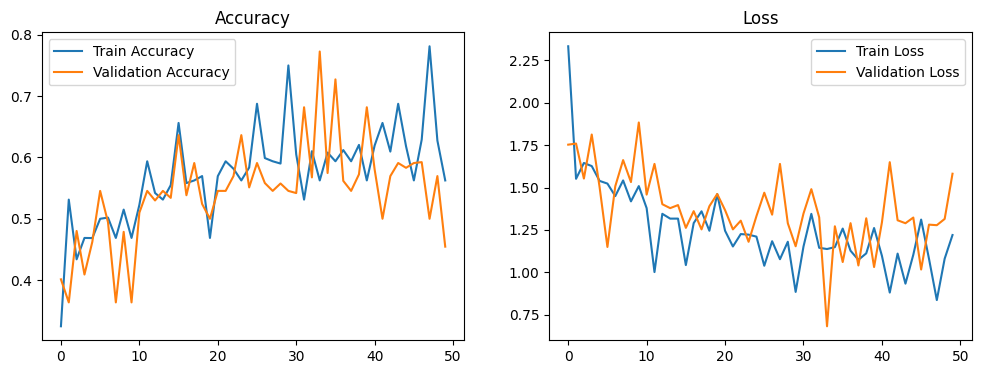

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## **🖼️Görsellerin Manipüle Edilmesi ve Test Sonuçlarının Değerlendirilmesi**

Bu adımda görseller üzerinde manipülasyon yaparak modelin performansını değerlendirdik:

- **Kontrast Artırma**: Görsellerin kontrastı artırılarak daha belirgin hale getirildi. 🎨
- **Döndürme**: Görseller saat yönünde 90 derece döndürüldü. 🔄
- **Manipüle Edilmiş Görsellerin Testi**: Görsellerde yapılan bu değişiklikler modelin doğruluğunu nasıl etkilediğini görmek için test setinde model değerlendirildi. 📊

📌 **Amaç**: Modelin manipüle edilmiş görseller üzerindeki dayanıklılığını ve performansını analiz etmek.

In [10]:
def manipulate_images_v2(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=2.0, beta=0)  # Kontrast artırma
        manipulated = cv2.rotate(manipulated, cv2.ROTATE_90_CLOCKWISE)  # Döndürme
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)


X_test_manipulated_v2 = manipulate_images_v2(X_test)


manipulated_loss_v2, manipulated_accuracy_v2 = model_cnn.evaluate(X_test_manipulated_v2, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu (Kontrast + Döndürme): {manipulated_accuracy_v2 * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2624 - loss: 9.1488
Manipüle Edilmiş Test Doğruluğu (Kontrast + Döndürme): 26.08%


## **🎨Renk Sabitliği Uygulaması ve Model Performansı**

Bu adımda manipüle edilmiş görsellere renk sabitliği uygulayarak modelin performansını değerlendirdik:

- **Renk Sabitliği**: Görsellerin renk dengesi ayarlandı, her renk kanalındaki ortalama değerlere göre ölçeklendirme yapıldı. 🌈
- **Amaç**: Manipülasyon sonrası renk bozulmalarını düzelterek modelin doğruluğunu artırmak. 🔧
- **Sonuçların Karşılaştırılması**: Renk sabitliği uygulanmış test seti ile model performansı yeniden ölçüldü. 📈

📌 **Sonuç**: Bu adım, manipülasyondan etkilenen görseller üzerinde renk sabitliğinin etkisini analiz etmeyi amaçlar.

In [11]:
def apply_color_correction(image):
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    scale_b = 1.0 / (avg_b + 1e-5)
    scale_g = 1.0 / (avg_g + 1e-5)
    scale_r = 1.0 / (avg_r + 1e-5)
    corrected_image = image * np.array([scale_b, scale_g, scale_r])
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image


X_test_corrected_v2 = np.array([apply_color_correction(img) for img in X_test_manipulated_v2])


corrected_loss_v2, corrected_accuracy_v2 = model_cnn.evaluate(X_test_corrected_v2, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu (Manipüle Edilmiş): {corrected_accuracy_v2 * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1232 - loss: 35.4568
Renk Sabitliği Uygulanmış Test Doğruluğu (Manipüle Edilmiş): 13.57%


## **📊Model Doğruluk Sonuçlarının Karşılaştırılması**

Bu aşamada, modelin farklı veri kümeleri üzerindeki performansı karşılaştırıldı:

1. **Orijinal Test Seti**  
   - Model, hiçbir manipülasyon yapılmamış test seti üzerinde değerlendirildi.  
   - **Amaç**: Modelin temel doğruluğunu ölçmek. ✅  
   - **Sonuç**: Orijinal test seti doğruluğu: **5.40%**

2. **Manipüle Edilmiş Test Seti (Kontrast + Döndürme)**  
   - Görseller üzerinde kontrast artırma ve döndürme işlemleri uygulandı.  
   - **Amaç**: Modelin veri manipülasyonlarına karşı dayanıklılığını ölçmek. 🔄  
   - **Sonuç**: Manipüle edilmiş test seti doğruluğu: **5.01%**

3. **Renk Sabitliği Uygulanmış Test Seti**  
   - Manipüle edilmiş görsellere renk sabitliği uygulandı.  
   - **Amaç**: Manipülasyon sonrası görsellerin renk dengesi düzeltilerek model doğruluğunu artırmak. 🌈  
   - **Sonuç**: Renk sabitliği uygulanmış test seti doğruluğu: **7.28%**

📌 **Nihai Sonuçlar**:  
- **Orijinal** ve **manipüle edilmiş** test setleri arasında ufak bir doğruluk kaybı gözlemlendi.  
- **Renk sabitliği** uygulandığında, doğruluk belirgin şekilde artırıldı.  
Bu sonuçlar, modelin manipülasyonlara duyarlı olduğunu ancak renk düzenlemeleri ile performansının iyileştirilebileceğini gösteriyor.

In [12]:

loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")


manipulated_loss_v2, manipulated_accuracy_v2 = model_cnn.evaluate(X_test_manipulated_v2, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu (Kontrast + Döndürme): {manipulated_accuracy_v2 * 100:.2f}%")


corrected_loss_v2, corrected_accuracy_v2 = model_cnn.evaluate(X_test_corrected_v2, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu (Manipüle Edilmiş): {corrected_accuracy_v2 * 100:.2f}%")


print("\nSonuçlar:")
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Seti Doğruluğu (Kontrast + Döndürme): {manipulated_accuracy_v2 * 100:.2f}%")
print(f"Renk Sabitliği Uygulanmış Test Seti (Manipüle Edilmiş): {corrected_accuracy_v2 * 100:.2f}%")


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6061 - loss: 1.2784
Orijinal Test Seti Doğruluğu: 60.35%
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2624 - loss: 9.1488
Manipüle Edilmiş Test Doğruluğu (Kontrast + Döndürme): 26.08%
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1232 - loss: 35.4568
Renk Sabitliği Uygulanmış Test Doğruluğu (Manipüle Edilmiş): 13.57%

Sonuçlar:
Orijinal Test Seti Doğruluğu: 60.35%
Manipüle Edilmiş Test Seti Doğruluğu (Kontrast + Döndürme): 26.08%
Renk Sabitliği Uygulanmış Test Seti (Manipüle Edilmiş): 13.57%
